In [20]:
#laos data viz!

In [87]:
#path configuration
to_data_parent = "../USAID-Laos-EV" #path to the parent folder, should contain program subfolders
to_data_folder = "../USAID-Laos-EV" #data folder, where composite data files will be written/read

program = "usaid_laos_ev"

dynamic_labels = {
    "MODE": [
      {"value":"walk", "baseMode":"WALKING", "met_equivalent":"WALKING", "kgCo2PerKm": 0},
      {"value":"e-auto_rickshaw", "baseMode":"MOPED", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.085416859},
      {"value":"auto_rickshaw", "baseMode":"MOPED", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.231943784},
      {"value":"motorcycle", "baseMode":"MOPED", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.113143309},
      {"value":"e-bike", "baseMode":"E_BIKE", "met": {"ALL": {"range": [0, -1], "mets": 4.9}}, "kgCo2PerKm": 0.00728},
      {"value":"bike", "baseMode":"BICYCLING", "met_equivalent":"BICYCLING", "kgCo2PerKm": 0},
      {"value":"drove_alone", "baseMode":"CAR", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.22031},
      {"value":"shared_ride", "baseMode":"CAR", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.11015},
      {"value":"e_car_drove_alone", "baseMode":"E_CAR", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.08216},
      {"value":"e_car_shared_ride", "baseMode":"E_CAR", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.04108},
      {"value":"taxi", "baseMode":"TAXI", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.30741},
      {"value":"bus", "baseMode":"BUS", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.20727},
      {"value":"train", "baseMode":"TRAIN", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.12256},
      {"value":"free_shuttle", "baseMode":"BUS", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.20727},
      {"value":"air", "baseMode":"AIR", "met_equivalent":"IN_VEHICLE", "kgCo2PerKm": 0.09975},
      {"value":"not_a_trip", "baseMode":"UNKNOWN", "met_equivalent":"UNKNOWN", "kgCo2PerKm": 0},
      {"value":"other", "baseMode":"OTHER", "met_equivalent":"UNKNOWN", "kgCo2PerKm": 0}
    ],
    "PURPOSE": [
      {"value":"home"},
      {"value":"work"},
      {"value":"at_work"},
      {"value":"school"},
      {"value":"transit_transfer"},
      {"value":"shopping"},
      {"value":"meal"},
      {"value":"pick_drop_person"},
      {"value":"pick_drop_item"},
      {"value":"personal_med"},
      {"value":"access_recreation"},
      {"value":"exercise"},
      {"value":"entertainment"},
      {"value":"religious"},
      {"value":"other"}
    ],
    "translations": {
      "en": {
        "walk": "Walk",
        "e-auto_rickshaw":"E-tuk tuk",
        "auto_rickshaw":"Tuk Tuk",
        "motorcycle":"Motorcycle",
        "e-bike": "E-bike",
        "bike": "Bicycle",
        "drove_alone": "Car Drove Alone",
        "shared_ride": "Car Shared Ride",
        "e_car_drove_alone": "E-Car Drove Alone",
        "e_car_shared_ride": "E-Car Shared Ride",
        "taxi": "Taxi/Loca/inDrive",
        "bus": "Bus",
        "train": "Train",
        "free_shuttle": "Free Shuttle",
        "air": "Airplane",
        "not_a_trip": "Not a trip",
        "home": "Home",
        "work": "To Work",
        "at_work": "At Work",
        "school": "School",
        "transit_transfer": "Transit transfer",
        "shopping": "Shopping",
        "meal": "Meal",
        "pick_drop_person": "Pick-up/ Drop off Person",
        "pick_drop_item": "Pick-up/ Drop off Item",
        "personal_med": "Personal/ Medical",
        "access_recreation": "Access Recreation",
        "exercise": "Recreation/ Exercise",
        "entertainment": "Entertainment/ Social",
        "religious": "Religious",
        "other": "Other"
      },
      "lo": {
        "walk": "ດ້ວຍການຍ່າງ",
        "e-auto_rickshaw":"ລົດ 3 ລໍ້ໄຟຟ້າ ຫລື ຕຸກຕຸກໄຟຟ້າ",
        "auto_rickshaw":"ເດີນທາດ້ວຍ ລົດຕຸກຕຸກ ຫລື ລົດສາມລໍ້",
        "motorcycle":"ລົດຈັກ",
        "e-bike": "ວຍລົດຈັກໄຟຟ້າ",
        "bike": "ລົດຖີບ",
        "drove_alone": "ເດີນທາງ ດ້ວຍລົດໃຫ່ຍ ເຊີ່ງເປັນລົດທີ່ຂັບເອງ",
        "shared_ride": "ເດີນທາງດ້ວຍລົດໃຫ່ຍ ຮ່ວມກັບລົດຄົນອຶ່ນ",
        "e_car_drove_alone": "ດ້ວຍການຂັບລົດໄຟຟ້າໄປເອງ",
        "e_car_shared_ride": "ດ້ວຍການຈ້າງລົດໄຟຟ້າໄປ",
        "taxi": "ແທັກຊີ",
        "bus": "ລົດເມ",
        "train": "ລົດໄຟ",
        "free_shuttle": "ລົດຮັບສົ່ງຟຣີ",
        "air": "ຍົນ",
        "not_a_trip": "ບໍ່ແມ່ນການເດີນທາງ",
        "home": "ບ້ານ",
        "work": "ໄປເຮັດວຽກ",
        "at_work": "ຢູ່ບ່ອນເຮັດວຽກ",
        "school": "ໄປໂຮງຮຽນ",
        "transit_transfer": "ການຖ່າຍໂອນການເດີນທາງ",
        "shopping": "ຊອບປິ້ງ",
        "meal": "ອາຫານ",
        "pick_drop_person": "ໄປຮັບ ຫລື ສົນ ຄົນ",
        "pick_drop_item": "ໄປຮັບ ຫລື ສົ່ງສິນຄ້າ",
        "personal_med": "ໄປຫາໝໍ",
        "access_recreation": "ເຂົ້າເຖິງການພັກຜ່ອນ",
        "exercise": "ພັກຜ່ອນ/ອອກກຳລັງກາຍ",
        "entertainment": "ບັນເທີງ/ສັງຄົມ",
        "religious": "ຈຸດປະສົງທາງສາດສະໜາ",
        "other": "ອື່ນໆ"
      }
    }
  }

In [88]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

params = {'legend.fontsize': 'small',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)


import importlib

In [90]:
print('starting with ', program)

#create dataset with surveys and trips
print(to_data_parent + '/' + program + '_trips.csv')
trips = pd.read_csv(to_data_parent + '/' + program + '_trips.csv')
print(len(trips), 'trips')
print(trips.user_id.nunique(), 'people')

surveys = pd.read_csv(to_data_parent + '/' + program + '_demographics.csv')
print(len(surveys), 'surveys')

#drop any null ids
socio_data = surveys[~surveys['user_id'].isnull()]
print(len(socio_data), 'surveys after dropping null ids')

#drop duplicates
socio_data = socio_data.sort_values(by=['user_id', 'data.ts'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)
print(len(socio_data),'surveys', socio_data['user_id'].nunique(), 'users after dropping duplicates')

#prepare survey ids for merging
socio_data['user_id_socio'] = socio_data['user_id'].astype(str)
socio_data['user_id_socio'] = socio_data['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
socio_data['user_id_socio'] = [i.replace('-','') for i in socio_data.user_id_socio]
socio_data['user_id_socio'] = socio_data['user_id_socio']
socio_data = socio_data.drop(labels='user_id', axis=1)


#prepare trip ids for merging
trips['user_id_socio'] = trips.user_id.astype(str)
trips['user_id_socio'] = trips['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
trips.user_id_socio = [i.replace('-','') for i in trips.user_id_socio] # remove all dashes from strings

#merge the data
data = trips.merge(socio_data, on='user_id_socio')
print(len(data), 'trips after merging')
print(data.user_id_socio.nunique(), 'people after merging')

data['program'] = program

starting with  usaid_laos_ev
../USAID-Laos-EV/usaid_laos_ev_trips.csv
6700 trips
24 people
28 surveys
28 surveys after dropping null ids
25 surveys 25 users after dropping duplicates
5841 trips after merging
22 people after merging


In [91]:
#merge them all together
full_data = data.copy()
print(len(full_data), 'trips')
print(full_data.user_id.nunique(), 'users')

5841 trips
22 users


In [94]:
print("DROPPING DATA BEFORE NOVEMBER")

full_data.drop(full_data[full_data['data.local_dt.month'] == 8].index)
full_data.drop(full_data[full_data['data.local_dt.month'] == 9].index)
full_data.drop(full_data[full_data['data.local_dt.month'] == 10].index)

print(len(full_data), 'trips')
print(full_data.user_id.nunique(), 'users')

DROPPING DATA BEFORE NOVEMBER
5841 trips
22 users


In [56]:
def mapping_labels(dynamic_labels, label_type):
    if "translations" in dynamic_labels and "en" in dynamic_labels["translations"]:
        translations = dynamic_labels["translations"]["en"]
        dic_mapping = dict()

        def translate_labels(labels):
            translation_mapping = {}
            for label in labels:
                value = label["value"]
                translation = translations.get(value)
                translation_mapping[value] = translation
            return defaultdict(lambda: 'Other', translation_mapping)
        dic_mapping = translate_labels(dynamic_labels[label_type])
        return dic_mapping

In [57]:
#readable labels!!
mode_map = mapping_labels(dynamic_labels, "MODE")
purpose_map = mapping_labels(dynamic_labels, "PURPOSE")

full_data['Mode_confirm'] = full_data['mode_confirm'].map(mode_map)
full_data['Trip_purpose'] = full_data['purpose_confirm'].map(purpose_map)

In [58]:
full_data.to_csv(to_data_folder + "/expanded_ct.csv")

In [95]:
# loading the data
data = pd.read_csv(to_data_folder + "/expanded_ct.csv")
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'data.distance', 'user_id',
       'data.start_fmt_time', 'data.duration', 'data.end_fmt_time',
       'mode_confirm', 'purpose_confirm', 'user_id_socio', '_id', 'data.ts',
       'At_your_primary_job_do_you_ha', 'Which_best_describes_your_prim',
       'Do_you_work_full_time_or_part_', 'Do_you_have_the_option_of_work',
       'Please_describe_your_primary_job', 'Do_you_have_more_than_one_job',
       'What_days_of_the_week_do_you_t', 'How_many_days_do_you_usually_w_001',
       'Which_one_below_describe_you_b', 'What_is_your_race_ethnicity',
       'Are_you_a_student', 'What_is_the_highest_grade_or_d',
       'do_you_consider_yourself_to_be', 'What_is_your_gender',
       'How_old_are_you', 'Are_you_a_paid_worker',
       'Do_you_have_a_driver_license', 'How_long_you_had_this_conditio',
       'Including_yourself_how_many_w_001', 'Including_yourself_how_many_p',
       'Do_you_own_or_rent_your_home', 'Please_identify_which_category',
       'How_ma

In [112]:
# Summary statistics table
print(len(pd.unique(data.user_id)))
stat_data = data[['data.distance','data.duration']]
stat_data.describe()

22


,data.distance
count,5841.000000
mean,14.343285
std,236.805844
min,0.102721
25%,0.880757
50%,2.595247
75%,6.061440
max,15046.857740


In [113]:
data['Please_identify_which_category'].unique()

array(['prefer_not_to_say', 'less_than__100', '_400_or_more',
       '_100_to__150'], dtype=object)

In [122]:
#format the age datapoints for the chart
data = data.replace(['_16_years_old',
              '16___20_years_old',
              '21___25_years_old', 
              '26___30_years_old', 
              '31___35_years_old',
              '36___40_years_old',
              '41___45_years_old', 
              '56___60_years_old'], 
             ['<16',
              '16-20',
              '21-25',
              '26-30',
              '31-35',
              '36-40',
              '41-45',
              '56-60'])

data['NUM_VEH'] = data['How_many_motor_vehicles_are_ow'].replace(
                                                ['prefer_not_to_say', 'more_than_3'], ['Prefer Not to Say', '> 3'])

data['STU'] = data['Are_you_a_student'].replace(['prefer_not_to_say', 'not_a_student', 'yes___full_time_college_university', 'yes___k_12th_grade_including_ged', 'yes___part_time_college_university'], 
                                                                ['Prefer Not to Say', 'Not a Student', 'Full-time\nUniversity', 'K-12 Student', 'Part-time\nUniversity'])

data['INC'] = data['Please_identify_which_category'].replace(['prefer_not_to_say','less_than__100', '_100_to__150', '_400_or_more'],
                                                             ['Prefer Not to Say', '< 100', '100-150', '> 400'])


data['STU'] = pd.Categorical(data['STU'], ['Prefer Not to Say', 'Not a Student', 'K-12 Student', 'Part-time\nUniversity', 'Full-time\nUniversity'])

In [123]:
data['STU'].unique()

['Full-time\nUniversity', 'Not a Student', 'Prefer Not to Say', 'K-12 Student', 'Part-time\nUniversity']
Categories (5, object): ['Prefer Not to Say', 'Not a Student', 'K-12 Student', 'Part-time\nUniversity', 'Full-time\nUniversity']

In [124]:
# Age, Income, Gender
plot_data = data.copy()
plot_data = plot_data.groupby(['user_id']).nth(0)[['How_old_are_you','What_is_your_gender','NUM_VEH', 'INC']].dropna()
plot_data = plot_data[plot_data['What_is_your_gender'].isin(['man','woman'])]
plot_data = plot_data.groupby(['user_id'], as_index=False).nth(0)

print(len(plot_data)) #22 participants

#order the values
plot_data['How_old_are_you'] = pd.Categorical(plot_data['How_old_are_you'], [ '<16',
                                                                              '16-20',
                                                                              '21-25',
                                                                              '26-30',
                                                                              '31-35',
                                                                              '36-40',
                                                                              '41-45',
                                                                              '46-50',
                                                                              '51-55',
                                                                              '56-60'])

plot_data['NUM_VEH'] = pd.Categorical(plot_data['NUM_VEH'], ['Prefer Not to Say', '0', '1', '2', '3', '> 3'])

plot_data['INC'] = pd.Categorical(plot_data['INC'], ['Prefer Not to Say', '< 100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '> 400'])

22


In [125]:
# plot_data['Please_identify_which_category'].unique()

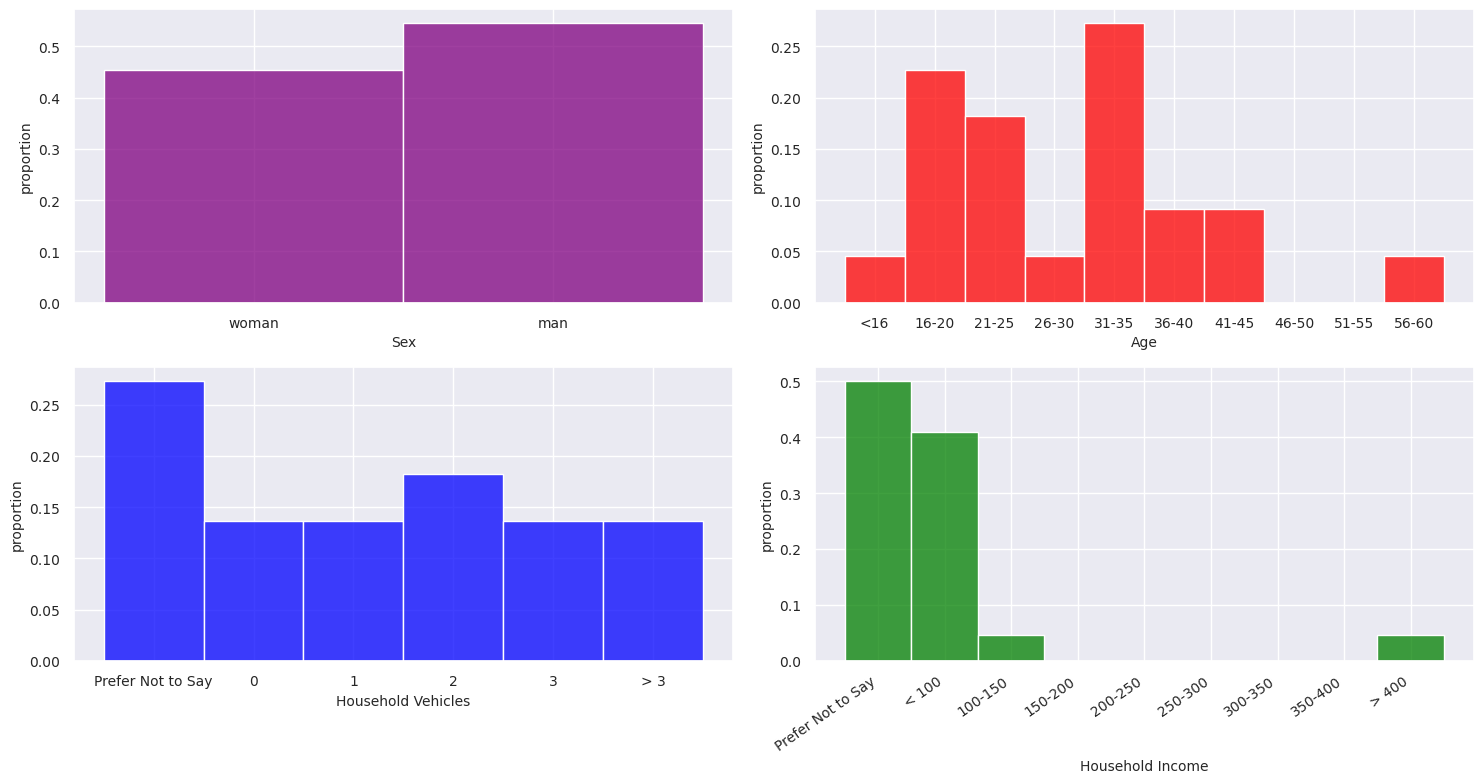

In [126]:
plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog'

fig, axs = plt.subplots(2,2,figsize=(15,8))
sns.histplot(data=plot_data, x='What_is_your_gender', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Sex',ylabel='proportion')
sns.histplot(data=plot_data, x='How_old_are_you', ax=axs[0,1], color='red', stat='probability').set(xlabel='Age',ylabel='proportion')
sns.histplot(data=plot_data, x='NUM_VEH', ax=axs[1,0], color='blue', stat='probability').set(xlabel='Household Vehicles',ylabel='proportion')
sns.histplot(data=pd.DataFrame(plot_data['INC'].dropna()), x='INC', ax=axs[1,1], color='green', stat='probability').set(xlabel='Household Income',ylabel='proportion')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(file_name+".png", bbox_inches='tight')

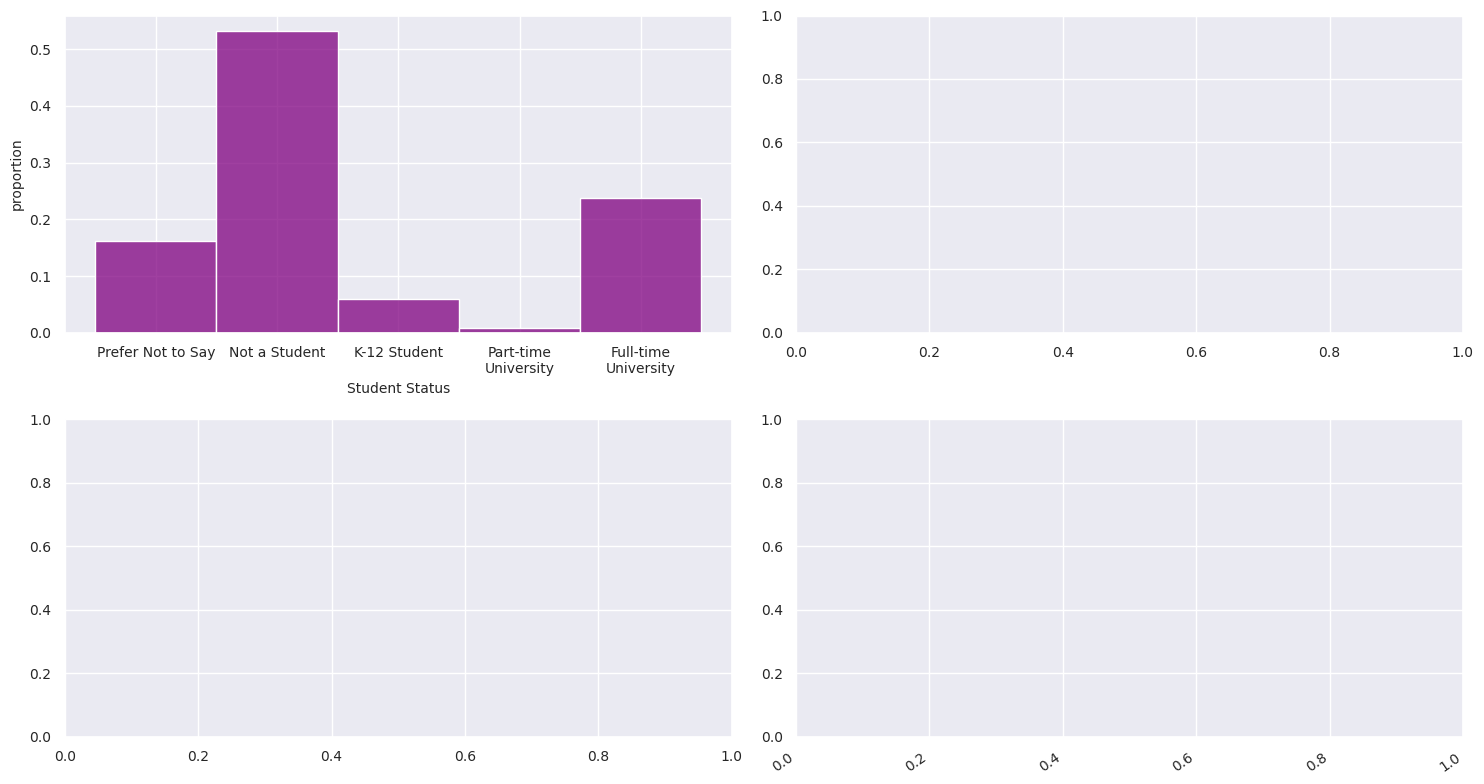

In [127]:
plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog'

fig, axs = plt.subplots(2,2,figsize=(15,8))
sns.histplot(data=data, x='STU', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Student Status',ylabel='proportion')

plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(file_name+".png", bbox_inches='tight')

In [21]:
labeled_data = data[data.mode_confirm.notna() | 
                         data.purpose_confirm.notna()]

print(len(labeled_data), 'labeled trips')
print(labeled_data.user_id_socio.nunique(), 'users who labeled')

1299 labeled trips
16 users who labeled


In [44]:
#gender - mode correlation
mode_gender_data=labeled_data.copy()
mode_gender_data = mode_gender_data[['What_is_your_gender', 'Mode_confirm', 'data.distance']]
mode_gender_data = mode_gender_data[mode_gender_data.Mode_confirm.notna()]

print(len(mode_gender_data))
mode_gender_data['What_is_your_gender'] = mode_gender_data['What_is_your_gender'].astype('category')
mode_gender_data['Mode_confirm'] = mode_gender_data['Mode_confirm'].astype('category')

gender_man = mode_gender_data[mode_gender_data['What_is_your_gender'] == 'man']
print(len(gender_man))
gender_woman = mode_gender_data[mode_gender_data['What_is_your_gender'] == 'woman']
print(len(gender_woman))

t1 = gender_man.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','data.distance']]
t1['proportion'] = t1['data.distance'] / np.sum(t1['data.distance'])
t1['trip_type'] = 'Man'
t1.columns = ['Mode','Count','Proportion','Gender']

# processing long data
t2 = gender_woman.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','data.distance']]
t2['proportion'] = t2['data.distance'] / np.sum(t2['data.distance'])
t2['trip_type'] = 'Woman'
t2.columns = ['Mode','Count','Proportion','Gender']

plot_data = pd.concat([t1, t2])
plot_data = plot_data.reset_index()
plot_data = plot_data.drop('index', axis='columns')

plot_data

1299
473
826


,Mode,Count,Proportion,Gender
0,Airplane,2,0.004228,Man
1,Bicycle,1,0.002114,Man
2,Car Drove Alone,14,0.029598,Man
3,Car Shared Ride,6,0.012685,Man
4,E-Car Drove Alone,1,0.002114,Man
5,E-Car Shared Ride,0,0.000000,Man
6,E-bike,3,0.006342,Man
7,E-tuk tuk,2,0.004228,Man
8,Motorcycle,396,0.837209,Man
9,Not a trip,0,0.000000,Man


In [62]:
display_data = plot_data.copy()
display_data = display_data.drop('Proportion', axis='columns')
display_data = display_data.set_index('Mode')

data_man = display_data[display_data['Gender']=='Man']
data_man = data_man.drop('Gender', axis='columns')
data_man.columns = ['Men(count)']
data_woman = display_data[display_data['Gender']=='Woman']
data_woman = data_woman.drop('Gender', axis='columns')
data_woman.columns = ['Women(count)']

test_data = data_man.merge(data_woman, on='Mode')
test_data['Total(count)'] = test_data['Men(count)'] + test_data['Women(count)']
test_data = test_data.sort_values(by="Total(count)", ascending=False)

test_data

,Men(count),Women(count),Total(count)
Mode,,,
Motorcycle,396,659,1055
Car Drove Alone,14,114,128
Walk,30,7,37
Other,17,13,30
Car Shared Ride,6,16,22
E-Car Drove Alone,1,6,7
Bicycle,1,3,4
E-bike,3,1,4
Not a trip,0,4,4


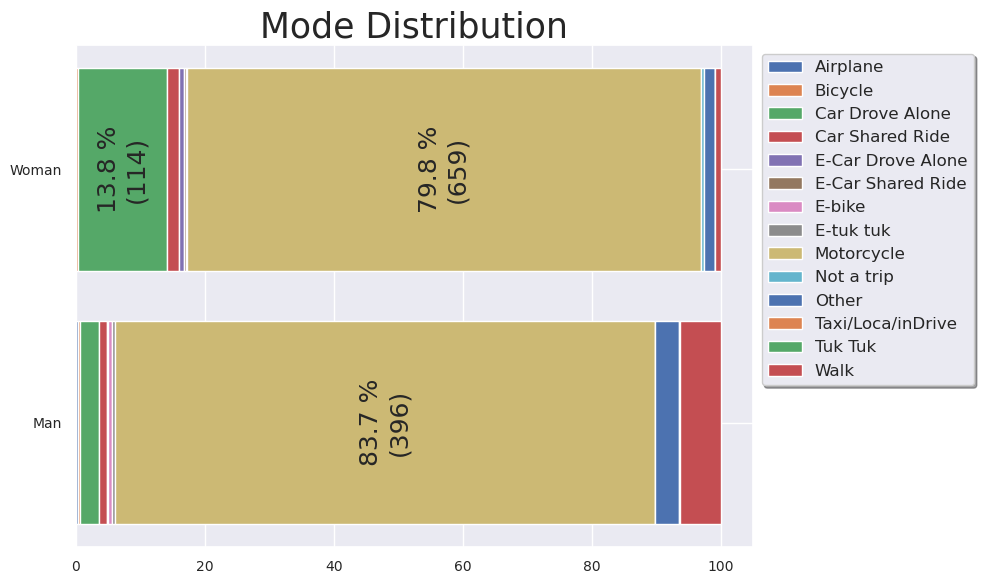

In [35]:
## code from minipilot vs full pilot regular / commute trip split -- has better labels!!

width = 0.8
fig, ax = plt.subplots(figsize=(10, 6))
running_total = [0,0]
fig_data = plot_data.copy()

plt.set_cmap('tab20')

for mode in pd.unique(fig_data.Mode):
    band_data = fig_data[fig_data['Mode']==mode]
    
    labels = band_data['Gender']
    vals = band_data['Proportion']*100
    bar_labels = band_data['Count']
    
    vals_str = [f'{y:.1f} %\n({x:,})' if y>10 else '' for x, y in zip(bar_labels, vals)]
    bar = ax.barh(labels, vals, width, left=running_total, label=mode)
    ax.bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=18)
    running_total[0] = running_total[0]+vals.iloc[0]
    running_total[1] = running_total[1]+vals.iloc[1]

ax.set_title('Mode Distribution', fontsize=25)
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=12)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.show()

In [ ]:
##vertical chart

test_data = plot_data.drop('Count', axis='columns')
data_man = test_data[test_data['Gender']=='Man']
data_woman = test_data[test_data['Gender']=='Woman']

data_man = data_man.drop('Gender', axis='columns')
data_man.columns = ['Mode','Man']
data_man = data_man.set_index('Mode')
data_man = data_man.transpose()

data_woman = data_woman.drop('Gender', axis='columns')
data_woman.columns = ['Mode','Woman']
data_woman = data_woman.set_index('Mode')
data_woman = data_woman.transpose()

test_data = pd.concat([data_man, data_woman])
test_data = test_data.fillna(0)


test_data

ax = test_data.plot.bar(stacked=True, 
                        title="Mode Share by Gender", 
                        ylabel="Proportion of Total Trip Count (%)",
                        xlabel = "Participant Gender",
                        rot = 0)

for c in ax.containers:
    labels = [f'{round(v.get_height()*100)}%' if v.get_height() > .05 else ''for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

ax.set_xticklabels(test_data.index, rotation=0, ha='center')
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=18)

ax.set_xlabel("Participant Gender", fontsize = 18)
ax.set_ylabel("Proportion of Total Trip Count (%)", fontsize = 18)
ax.set_title("Mode Share by Gender", fontsize = 22)

plt.savefig("CanBikeCO_report_age_mode_share.jpeg", bbox_inches='tight')


##this would be better if we also had the counts!!!

<Axes: xlabel='data.distance', ylabel='Count'>

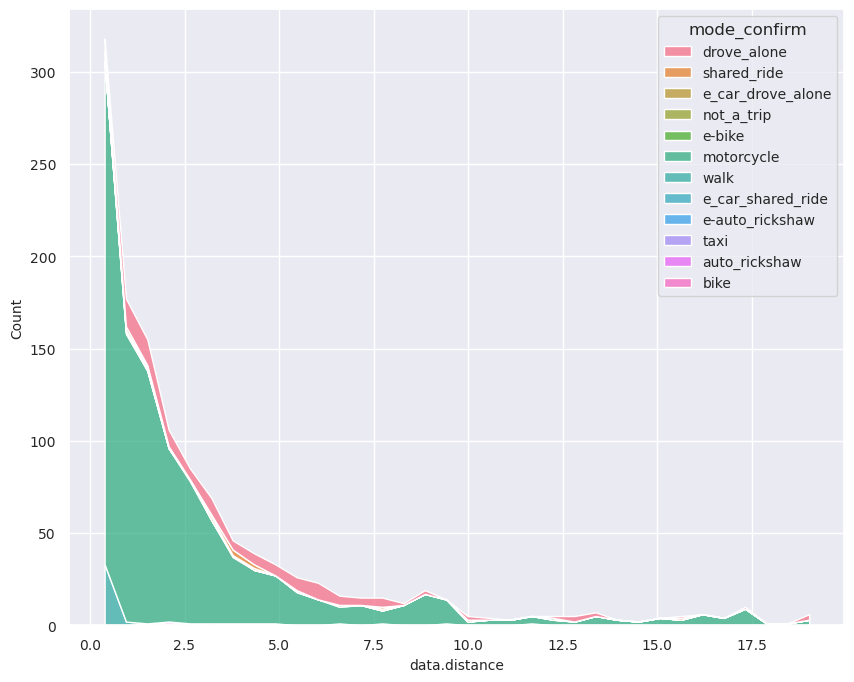

In [26]:
plot_data = labeled_data.copy()
plot_data = plot_data[plot_data['data.distance']<20]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="data.distance", hue="mode_confirm", element="poly", multiple="stack")

In [ ]:
plot_data = data.copy()
plot_data = plot_data[plot_data['data.distance']<6]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="data.distance", hue="mode_confirm", element="poly", multiple="stack")

In [ ]:
## DISTANCE BY MODE -- WANT 1 for Man and 1 for Woman!

# Distribution of distances by program
plot_data = data.copy()

#get rid of planes - outliers!
plot_data = plot_data[plot_data['mode_confirm'] != 'air']
plot_data = plot_data[plot_data['mode_confirm'] != 'taxi']
plot_data = plot_data[plot_data['mode_confirm'] != 'auto_rickshaw']

plot_title = 'Distribution of Distances by Mode'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='mode_confirm', y='data.distance', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

In [ ]:
#experimenting with the trajectories

In [ ]:
print('starting with ', program)

#create dataset with surveys and trips
# print(to_data_parent + '/' + program + '_trips.csv')
# trips = pd.read_csv(to_data_parent + '/' + program + '_trips.csv')
# print(len(trips), 'trips')
# print(trips.user_id.nunique(), 'people')

surveys = pd.read_csv(to_data_parent + '/' + program + '_demographics.csv')
print(len(surveys), 'surveys')

trajs = pd.read_csv(to_data_parent + '/' + program + '_trajectories.csv')
print(len(trajs), 'trajectories')

#drop any null ids
socio_data = surveys[~surveys['user_id'].isnull()]
print(len(socio_data), 'surveys after dropping null ids')

#drop duplicates
socio_data = socio_data.sort_values(by=['user_id', 'data.ts'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)
print(len(socio_data),'surveys', socio_data['user_id'].nunique(), 'users after dropping duplicates')

#prepare survey ids for merging
socio_data['user_id_socio'] = socio_data['user_id'].astype(str)
socio_data['user_id_socio'] = socio_data['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
socio_data['user_id_socio'] = [i.replace('-','') for i in socio_data.user_id_socio]
socio_data['user_id_socio'] = socio_data['user_id_socio']
socio_data = socio_data.drop(labels='user_id', axis=1)

# #prepare trip ids for merging
# trips['user_id_socio'] = trips.user_id.astype(str)
# trips['user_id_socio'] = trips['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
# trips.user_id_socio = [i.replace('-','') for i in trips.user_id_socio] # remove all dashes from strings

#prepare traj ids for merging
trajs['user_id_socio'] = trajs.user_id.astype(str)
trajs['user_id_socio'] = trajs['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
trajs.user_id_socio = [i.replace('-','') for i in trajs.user_id_socio] # remove all dashes from strings

# #merge the data
# data = trips.merge(socio_data, on='user_id_socio')
# print(len(data), 'trips after merging')
# print(data.user_id_socio.nunique(), 'people after merging')

#merge the trajectories
traj_data = trajs.merge(socio_data, on='user_id_socio')
print(len(traj_data), 'trajs after merging')
print(traj_data.user_id_socio.nunique(), 'people after merging')

traj_data['program'] = program

In [ ]:
traj_data.columns

In [ ]:
traj_data['data.distance'].max()

In [ ]:
plot_data = traj_data.copy()
plot_data = plot_data[plot_data['data.distance']<200]

plot_title = 'Distribution of Distances by Mode'
ylab = 'Distance (meters?)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='data.mode_str', y='data.distance', hue='data.mode_str', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

#not really seeming reliable or significant ... outliers? 

In [ ]:
plot_data = traj_data.copy()

In [ ]:
plot_data.columns

In [ ]:
plot_data['date'] = str(plot_data['data.local_dt.year']) + str(plot_data['data.local_dt.month']) + str(plot_data['data.local_dt.day'])

In [ ]:
plot_data['date'].unique()